# Importing Packages and Loading Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
file_path_users = 'takehome_users.csv'
file_path_sessions = 'takehome_user_engagement.csv'
df_users = pd.read_csv(file_path_users, encoding='iso-8859-1')
df_sessions = pd.read_csv(file_path_sessions, encoding='iso-8859-1')

In [3]:
df_users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [4]:
df_sessions.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [5]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [6]:
df_sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


# Data Cleaning

Changing column name from `objec_id` to `user_id` to make joining the tables later easier.

In [7]:
df_users = df_users.rename(columns={'object_id':'user_id'})

Changing date data dtypes from object to datetime. This will be useful later for plotting.

In [8]:
df_users['creation_time'] = df_users['creation_time'].apply(lambda x: pd.to_datetime(x))
df_users['last_session_creation_time'] = df_users['last_session_creation_time'].apply(lambda x: pd.to_datetime(x, unit='s'))
df_sessions['time_stamp'] = df_sessions['time_stamp'].apply(lambda x: pd.to_datetime(x))

# Defining Target Feature  
Creating intermediate dataframe `df_users_2` in order to count how many times a user has logged in on different days. If logged in 3 or more times, define as an adopted user

In [9]:
df_sessions['time_stamp_day'] = df_sessions['time_stamp'].dt.floor('D')
df_users_2 = df_sessions.groupby('user_id')[['time_stamp_day']].agg(lambda x: len(x.drop_duplicates())).reset_index().rename(columns={'time_stamp_day':'n_logins_user'})
df_users_2['adopted_user'] = df_users_2['n_logins_user'] >= 3
df_users_2.head()

,user_id,n_logins_user,adopted_user
0,1,1,False
1,2,14,True
2,3,1,False
3,4,1,False
4,5,1,False


Join newly created dataframe with original, df_users, on `user_id`.

**If a user from the `df_users` table does not show up in `df_users_2`, we assume it is becasue they have not logged in. We therfore categorize them as not adopted.**

In [10]:
df_users = df_users.merge(df_users_2, how='left', on='user_id')
df_users['n_logins_user'] = df_users['n_logins_user'].fillna(0).astype(int)
df_users['adopted_user'] = df_users['adopted_user'].fillna(False)

In [11]:
df_users.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,n_logins_user,adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,1,False
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,14,True
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,1,False
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,1,False
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,1,False


In [12]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   user_id                     12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   datetime64[ns]
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          6417 non-null   float64       
 10  n_logins_user               12000 non-null  int64         
 11  adopted_user                12000 non-null  bool      

Percentage of users considered "adopted". This shows the data is very imbalanced.

In [13]:
df_users['adopted_user'].value_counts() / df_users.shape[0] * 100

False    81.266667
True     18.733333
Name: adopted_user, dtype: float64

# Exploratory Data Analysis

Count plots for categorical data.

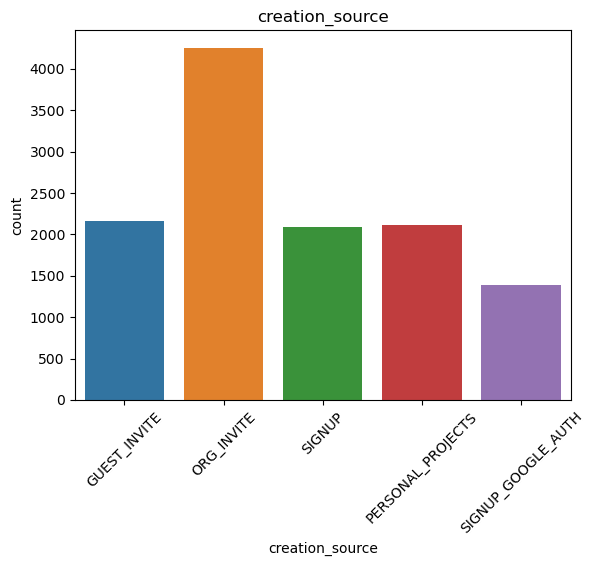

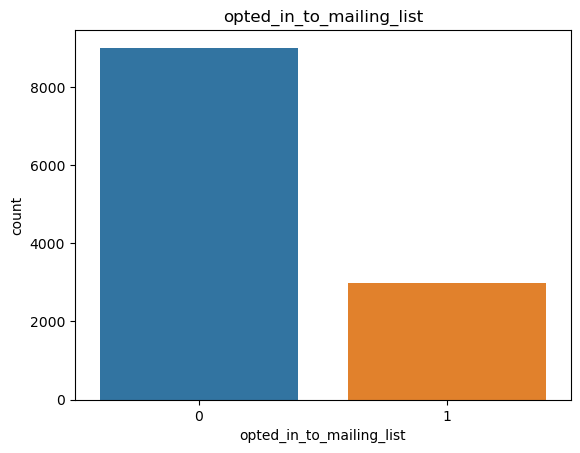

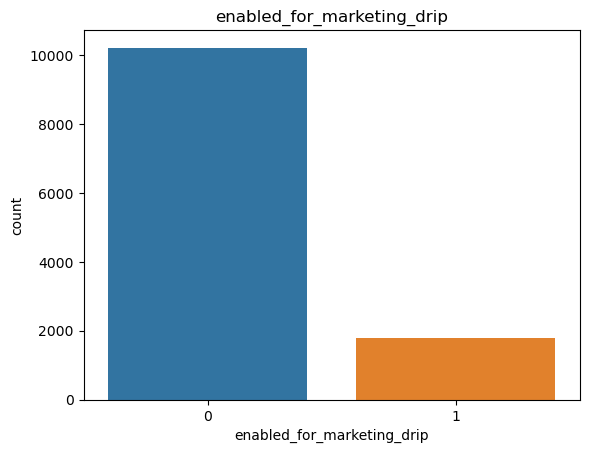

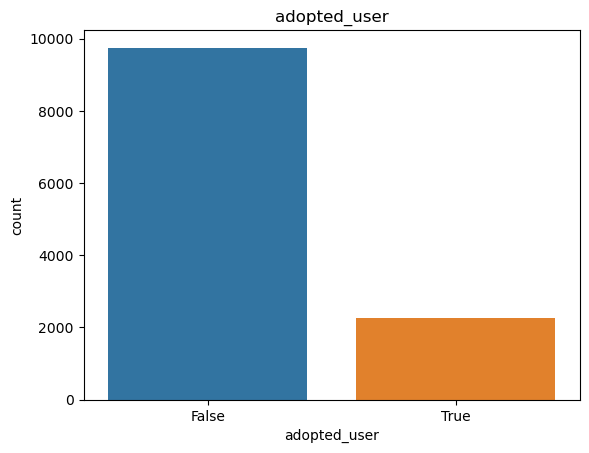

In [14]:
for column in ['creation_source', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'adopted_user']:
    sns.countplot(df_users, x=column)
    if column == 'creation_source':
        plt.xticks(rotation=45)
    plt.title(column)
    plt.show()

Histograms

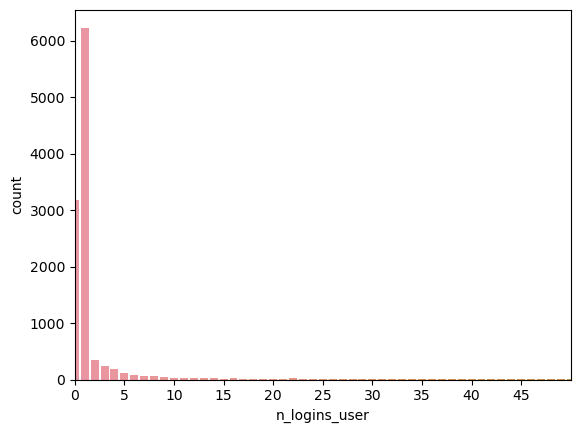

In [15]:
sns.countplot(df_users, x='n_logins_user')
plt.xlim([0, 50])
plt.xticks(np.arange(0, 50, 5))
plt.show()

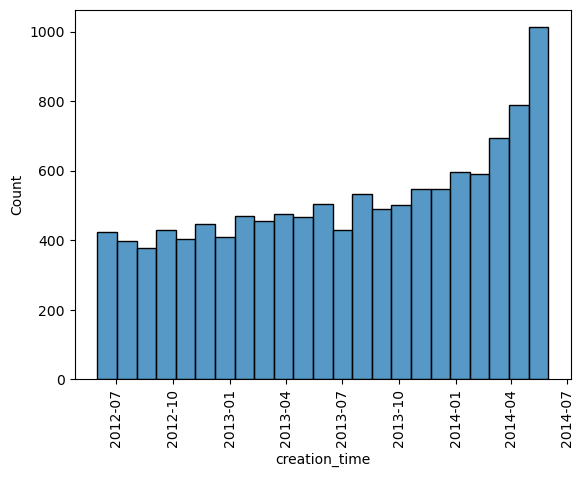

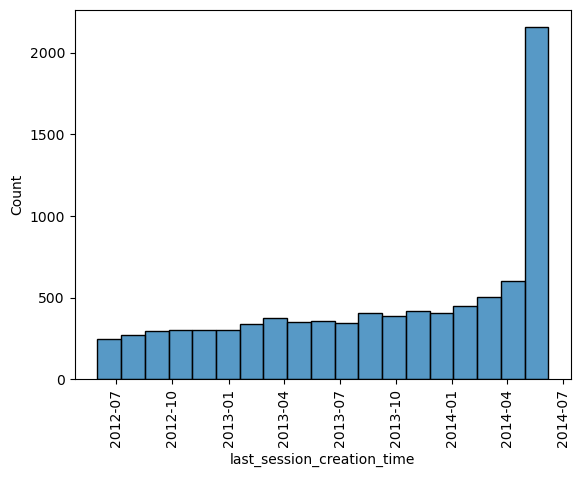

In [16]:
for column in ['creation_time', 'last_session_creation_time']:
    sns.histplot(df_users, x=column)
    plt.xticks(rotation=90)
    plt.show()

# Preprocessing

Changing date data into integer type. The integer represents the number of days starting from the earliest date found in the feature `creation_time`.

In [17]:
start_day = df_users['creation_time'].sort_values().iloc[0].floor('D')
df_users['creation_time_int'] = (df_users['creation_time'].dt.floor('D') - start_day).dt.days
df_users['last_session_creation_time_int'] = (df_users['last_session_creation_time'].dt.floor('D') - start_day).dt.days

We impute missing values for `last_session_creation_time_int` with an integer value 999 which does not show up in the raw data.

In [18]:
#Cheking available values of feature. We choose an integer number that does not show up to represent "no login".
df_users['last_session_creation_time_int'].dropna().sort_values()

9898       0.0
10011      0.0
11429      1.0
10162      1.0
1994       1.0
         ...  
5328     734.0
4471     734.0
6653     734.0
11499    734.0
4050     736.0
Name: last_session_creation_time_int, Length: 8823, dtype: float64

In [19]:
df_users['last_session_creation_time_int'] = df_users['last_session_creation_time_int'].fillna(999)
df_users['last_session_creation_time_int'] = df_users['last_session_creation_time_int'].astype(int)

Change categorical feature `creation_source_int` by label encoding.

In [20]:
from sklearn.preprocessing import LabelEncoder

df_users['creation_source_int'] = LabelEncoder().fit_transform(df_users['creation_source'])

Change bool dtype of feature `adopted_user` to int.

In [21]:
df_users['adopted_user'] = df_users['adopted_user'].astype(int)

In [22]:
df_users.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,n_logins_user,adopted_user,creation_time_int,last_session_creation_time_int,creation_source_int
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,1,0,691,691,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,14,1,533,669,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,1,0,292,292,1
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,1,0,355,356,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,1,0,231,236,0


In [23]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   user_id                         12000 non-null  int64         
 1   creation_time                   12000 non-null  datetime64[ns]
 2   name                            12000 non-null  object        
 3   email                           12000 non-null  object        
 4   creation_source                 12000 non-null  object        
 5   last_session_creation_time      8823 non-null   datetime64[ns]
 6   opted_in_to_mailing_list        12000 non-null  int64         
 7   enabled_for_marketing_drip      12000 non-null  int64         
 8   org_id                          12000 non-null  int64         
 9   invited_by_user_id              6417 non-null   float64       
 10  n_logins_user                   12000 non-null  int64         
 11  ad

# Training

Define feature matrix and target feature.

In [24]:
features = [x for x in df_users.columns if x not in ['user_id', 'creation_time', 'name', 'email', 'creation_source', 'last_session_creation_time', 'invited_by_user_id', 'n_logins_user', 'adopted_user']]
X = df_users[features]
y = df_users['adopted_user']

In [25]:
X.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,creation_time_int,last_session_creation_time_int,creation_source_int
0,1,0,11,691,691,0
1,0,0,1,533,669,1
2,0,0,94,292,292,1
3,0,0,1,355,356,0
4,0,0,193,231,236,0


In [26]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 6 columns):
 #   Column                          Non-Null Count  Dtype
---  ------                          --------------  -----
 0   opted_in_to_mailing_list        12000 non-null  int64
 1   enabled_for_marketing_drip      12000 non-null  int64
 2   org_id                          12000 non-null  int64
 3   creation_time_int               12000 non-null  int64
 4   last_session_creation_time_int  12000 non-null  int64
 5   creation_source_int             12000 non-null  int64
dtypes: int64(6)
memory usage: 656.2 KB


Train-test split.

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

Oversampling the data since it is very imbalanced.

In [28]:
from imblearn.over_sampling import RandomOverSampler

X_train_res, y_train_res = RandomOverSampler().fit_resample(X_train, y_train)

Building model.

In [29]:
from xgboost import XGBClassifier

model = XGBClassifier().fit(X_train_res, y_train_res)
y_pred_train = model.predict(X_train)
y_pred = model.predict(X_test)

# Model Evaluation

In [30]:
from sklearn.metrics import classification_report, RocCurveDisplay

print(classification_report(y_train, y_pred_train))
print()
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7802
           1       0.98      1.00      0.99      1798

    accuracy                           1.00      9600
   macro avg       0.99      1.00      0.99      9600
weighted avg       1.00      1.00      1.00      9600


              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1950
           1       0.97      0.94      0.96       450

    accuracy                           0.98      2400
   macro avg       0.98      0.97      0.97      2400
weighted avg       0.98      0.98      0.98      2400



Feature importance

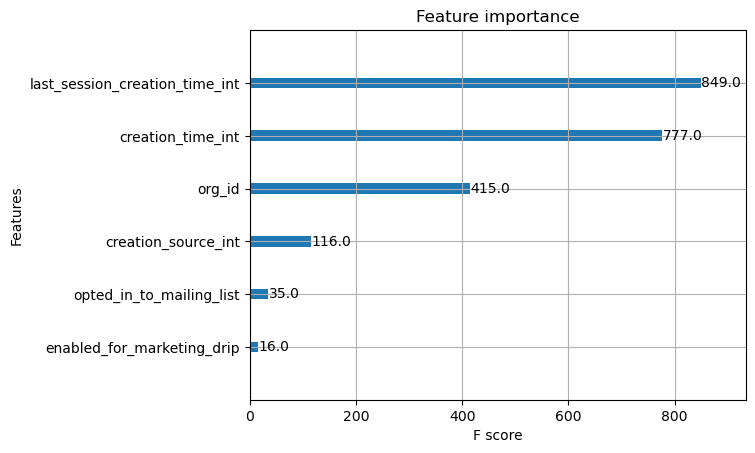

In [31]:
from xgboost import plot_importance

plot_importance(model)
plt.show()

# Remarks

A model was build that can predict adopted users suprisingly well. It appears the biggest contributing factors in the prediction are the day of their last session login and the date when they created the account. The organization of the individual seems to also be an important contributor.